# Implementación de nuestro sistema de recomendación con base de datos de Netflix

A continuación mostraremos todo el desarrollo de la implementación de nuestro modelo de sistemas de recomendación de películas bajo el enfoque colaborativo para nuestra base de datos de Netlflix que contiene las calificaciones ru,j en escala de 1 a 5 asignadas para una muestra de usuarios de la plataforma.

In [6]:
md("Este desarrollo se encuentra organizado de la siguiente manera:\
\n * En primer lugar, mostraremos la **Implementación del Sistema de Recomendación de películas a usuarios con una base de datos {}** que se refiere a un extracto de la base original (Netflix Prize) con {:,} de registros, {:,} número de usuarios y {:,} número de películas misma que fue tomada de nuestras notas de referencia (AGREGAR LIGA). Para fines ilustrativos, se añade además un ejemplo con las recomendaciones de películas que genera nuestro sistema seleccionanddo un usuario al azar del conjunto de prueba.\
\n\n * Posteriormente y a modo de complemento, se incluye una **Implementación de un modelo predictivo con parámetros sin ajustar para estimar las calificaciones de usuarios a las películas con el dataset completo del Concurso Netflix Prize** que se conforma por (Agregar total de registros, número de usuarios y películas). Esto con el objetivo exhibir que la implementación dentro de libmf permite calcular estimaciones a una matriz R con datasets reales teniendo tiempos de ejecución menores a 1 minuto gracias a sus métodos FPSG (Fast Parallel Sthocastic Gradient) y RPCS (Reduced Per-Coordinate Schedule).\
".format(base,df.shape[0],num_usuarios,num_peliculas))

Este desarrollo se encuentra organizado de la siguiente manera:
 * En primer lugar, mostraremos la **Implementación del Sistema de Recomendación de películas a usuarios con una base de datos MUESTRA** que se refiere a un extracto de la base original (Netflix Prize) con 20,968,941 de registros, 100,000 número de usuarios y 17,770 número de películas misma que fue tomada de nuestras notas de referencia (AGREGAR LIGA). Para fines ilustrativos, se añade además un ejemplo con las recomendaciones de películas que genera nuestro sistema seleccionanddo un usuario al azar del conjunto de prueba.

 * Posteriormente y a modo de complemento, se incluye una **Implementación de un modelo predictivo con parámetros sin ajustar para estimar las calificaciones de usuarios a las películas con el dataset completo del Concurso Netflix Prize** que se conforma por (Agregar total de registros, número de usuarios y películas). Esto con el objetivo exhibir que la implementación dentro de libmf permite calcular estimaciones a una matriz R con datasets reales teniendo tiempos de ejecución menores a 1 minuto gracias a sus métodos FPSG (Fast Parallel Sthocastic Gradient) y RPCS (Reduced Per-Coordinate Schedule).

A continuación se cargan las librerías:

In [1]:
# pip install libmf
import pandas as pd
from IPython.display import Markdown as md
import seaborn as sns
from pylab import savefig
import numpy as np
import copy
from IPython.core.display import Image, display
import matplotlib.pyplot as plt
import seaborn as sns
import libmf
from libmf import mf

Using file found in /home/miuser/.local/lib/python3.6/site-packages:
/home/miuser/.local/lib/python3.6/site-packages/libmf.cpython-36m-x86_64-linux-gnu.so


In [2]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [82]:
#Base con los nombres de las películas
pelis_nombres=pd.read_csv('/datos/datasets/movies_title_fix.csv',names=["peli_id", "año", "nombre"])

#Elige la base:
base='MUESTRA' #'muestra' si se quiere una muestra de la base completa de Netflix; '' (vacío) si se quiere la base completa de Netflix

if base=='MUESTRA':
    df=pd.read_csv('/datos/datasets/dat_muestra_nflix.csv',sep=',',usecols=['usuario_id','peli_id','calif'])[['usuario_id','peli_id','calif']]
else:
    df=pd.read_csv('/datos/datasets/netflix_complete_cleaned.txt',sep=' ', header = None, names = ['usuario_id','peli_id','calif'], usecols = [0,1,2])

In [5]:
num_usuarios=df['usuario_id'].nunique()
num_peliculas=df['peli_id'].nunique()
num_calif=df['calif'].nunique()
usuarios_min=df['usuario_id'].min()
usuarios_max=df['usuario_id'].max()
peliculas_min=df['peli_id'].min()
peliculas_max=df['peli_id'].max()
calif_min=df['calif'].min()
calif_max=df['calif'].max()

## Análisis exploratorio: Base Muestra de Netflix

Como primer paso, se da lectura a la base y se muestra un análisis exploratorio de los datos para entender cuáles son sus características.

Las base contiene el id de los usuarios de Netflix, el id de las películas, la calificación y fecha, aunque esta última no la utilizaremos para la construcción de este modelo. A continuación se muestra cuantos id's de usuarios y películas se tienen, 

In [7]:
md("\
<table>\
  <thead>\
    <tr>\
      <th></th>\
      <th>usuario_id</th>\
      <th>peli_id</th>\
      <th>calif</th>\
    </tr>\
  </thead>\
  <tbody>\
    <tr>\
      <td>Valores distintos</td>\
      <td style='text-align:center'>{:,}</td>\
      <td style='text-align:center'>{:,}</td>\
      <td style='text-align:center'>{:,}</td>\
    </tr>\
    <tr>\
      <td>Rango</td>\
      <td style='text-align:center'>{:,}-{:,}</td>\
      <td style='text-align:center'>{:,}-{:,}</td>\
      <td style='text-align:center'>{:,}-{:,}</td>\
    </tr>\
    <tr>\
      <td>Tipo variable</td>\
      <td style='text-align:center'>{}</td>\
      <td style='text-align:center'>{}</td>\
      <td style='text-align:center'>{}</td>\
    </tr>\
  </tbody>\
</table>\
".format(num_usuarios,num_peliculas,num_calif,usuarios_min,usuarios_max,peliculas_min,peliculas_max,calif_min,calif_max,df['usuario_id'].dtype,df['peli_id'].dtype,df['calif'].dtype))

#<img src='.\hist1.png' alt='' border=3 height=200 width=500></img>

<table>  <thead>    <tr>      <th></th>      <th>usuario_id</th>      <th>peli_id</th>      <th>calif</th>    </tr>  </thead>  <tbody>    <tr>      <td>Valores distintos</td>      <td style='text-align:center'>100,000</td>      <td style='text-align:center'>17,770</td>      <td style='text-align:center'>5</td>    </tr>    <tr>      <td>Rango</td>      <td style='text-align:center'>1-100,000</td>      <td style='text-align:center'>1-17,770</td>      <td style='text-align:center'>1-5</td>    </tr>    <tr>      <td>Tipo variable</td>      <td style='text-align:center'>int64</td>      <td style='text-align:center'>int64</td>      <td style='text-align:center'>int64</td>    </tr>  </tbody></table>

### Top Usuarios y Películas con más evaluaciones

En las tablas siguientes se puede observar que existe un reducido numero de usuarios que han calificado un gran numero de películas distintas, lo cual se podría deber a que a una misma cuenta de netflix podrían tener acceso varias personas.

Similarmente, para las películas se observa que existen varias películas con una gran cantidad de calificaciones

Respecto a la calificación en sí, la cual varía entre 1,2,3,4 y 5, se nota que la mayoría de las personas que califica lo hace con un 3 o 4

In [8]:
frec_usuario_id=pd.crosstab(index=df["usuario_id"],columns="frecuencia_usuario_id")
frec_usuario_id=frec_usuario_id.sort_values(by=['frecuencia_usuario_id'],ascending=False)
frec_usuario_id.columns.name=''

frec_peli_id=pd.crosstab(index=df["peli_id"],columns="frecuencia_peli_id")
frec_peli_id=frec_peli_id.sort_values(by=['frecuencia_peli_id'],ascending=False)
frec_peli_id.columns.name=''

frec_calif=pd.crosstab(index=df["calif"],columns="frecuencia_calif")
frec_calif=frec_calif.sort_values(by=['frecuencia_calif'],ascending=False)
frec_calif.columns.name=''

In [9]:
#Se guardan los dataframes en un formato conveniente para imporimir lado a lado
df1_styler = frec_usuario_id.head(10).style.set_table_attributes("style='display:inline'").set_caption('NO. DE CALIFICACIONES POR USUARIO')
df2_styler = frec_peli_id.head(10).style.set_table_attributes("style='display:inline'").set_caption('NO. CALIFICACIONES POR PELÍCULA')
df3_styler = frec_calif.head(10).style.set_table_attributes("style='display:inline'").set_caption('FRECUENCIA DE CALIFICACIONES')

space="\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0"
di.display_html(df1_styler._repr_html_()+space+df2_styler._repr_html_()+space+df3_styler._repr_html_(), raw=True)

,frecuencia_usuario_id
usuario_id,
42,15813
89,14831
132,9822
125,9064
2718,6736
545,6074
88,5867
1000,5748
6,4913


Para finalizar la exploración individual de las 3 columnas que reportamos de la base, se obtuvo un historgrama de los id's de usuario, película y calificaciones, donde se observa que en el caso de usuarios, existe una gran variación en el número de calificaciones que han realizado. En el caso de las películas, el numero de calificaciones que han recibido cada una es también variable, pero no tanto.

In [15]:
## Este código exhibe las 3 gráficas lado a lado, pero tarda mucho en correr
# sns.set_style('darkgrid')
# fig, ax =plt.subplots(1,3)
# # plt.figure(figsize=(25,5))
# sns.countplot(df['usuario_id'], ax=ax[0])
# sns.countplot(df['peli_id'], ax=ax[1])
# sns.countplot(df['calif'], ax=ax[2])
# fig.show()

### Histograma no. calificaciones por usuario

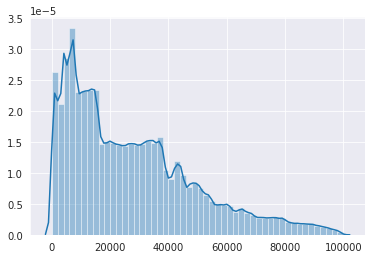

In [12]:
sns.set_style('darkgrid')
hist1=sns.distplot(df[['usuario_id']])
hist1
figure_hist1=hist1.get_figure()    
figure_hist1.savefig('hist1')

### Histograma no. calificaciones por película

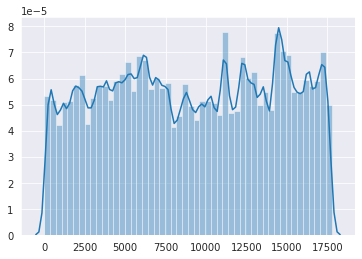

In [13]:
sns.set_style('darkgrid')
hist2=sns.distplot(df[['peli_id']])
hist2
figure_hist2=hist2.get_figure()    
figure_hist2.savefig('hist2')

### Histograma no. calificaciones por película

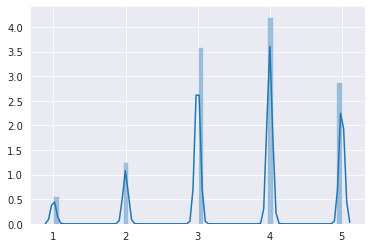

In [14]:
sns.set_style('darkgrid')
hist3=sns.distplot(df[['calif']])
hist3
figure_hist3=hist3.get_figure()    
figure_hist3.savefig('hist3')

Existen películas con calificación promedio alta, que fueron calificadas por pocos o muchos usuarios, pero en el caso de las películas con los perores promedios, éstas consistentemente fueron calificadas por pocos usuarios. Cuando se observa las películas más calificadas, estas no muestran tener promedios muy altos.

In [10]:
df_group_peli_id=df[['peli_id','calif']].groupby(['peli_id']).agg({'calif': ['count','mean']}).rename(columns={'count':'num_calificaciones','mean':'calif_prom'})
df_group_peli_id.columns=['num_calificaciones','calif_prom']
df_group_peli_id=df_group_peli_id.sort_values(by=['calif_prom','num_calificaciones'],ascending=False)

df1_styler = df_group_peli_id.head(10).style.set_table_attributes("style='display:inline'").set_caption('PELÍCULAS CON MEJOR CALIF PROMEDIO')
df2_styler = df_group_peli_id.tail(10).style.set_table_attributes("style='display:inline'").set_caption('PELÍCULAS CON MENOR CALIF PROMEDIO')

df_group_peli_id=df_group_peli_id.sort_values(by=['num_calificaciones','calif_prom'],ascending=False)

df3_styler = df_group_peli_id.head(10).style.set_table_attributes("style='display:inline'").set_caption('PELÍCULAS MÁS CALIFICADAS')
df4_styler = df_group_peli_id.tail(10).style.set_table_attributes("style='display:inline'").set_caption('PELÍCULAS MENOS CALIFICADAS')

space="\xa0\xa0\xa0\xa0"
di.display_html(df1_styler._repr_html_()+space+df2_styler._repr_html_()+space+df3_styler._repr_html_()+space+df4_styler._repr_html_(), raw=True)

,num_calificaciones,calif_prom
peli_id,,
14791,17,4.882353
8964,6,4.833333
6522,29,4.758621
4614,4,4.750000
14961,15260,4.724050
7230,15191,4.712066
15538,329,4.696049
7057,15528,4.694874
9864,364,4.678571


La siguiente tabla muestra la distribución de la población acorde a las películas y el número de calificaciones que éstas han recibido, donde se pude ver que el 60% de las películas calificó entre 1 y 210 películas

In [11]:
quantiles=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
bins=pd.to_numeric(df_group_peli_id['num_calificaciones'].quantile(quantiles),downcast='integer').to_list()

aux=copy.copy(df_group_peli_id)
aux["num_calificaciones_group"] = pd.cut(aux["num_calificaciones"], bins=bins)
num_peli_id_by_num_calificaciones=(aux.groupby("num_calificaciones_group").agg(num_usuarios_id=("num_calificaciones", "count")))

num_peli_id_by_num_calificaciones.columns=['quantil_num_usuarios_id']
num_peli_id_by_num_calificaciones['percentil']=quantiles[1::]
num_peli_id_by_num_calificaciones=num_peli_id_by_num_calificaciones[['percentil']]

df1_styler = num_peli_id_by_num_calificaciones.style.set_table_attributes("style='display:inline'").set_caption('Distribución población acorde a numero de calificaciones que recibió cada película')
di.display_html(df1_styler._repr_html_(), raw=True)

,percentil
num_calificaciones_group,
"(1, 25]",0.100000
"(25, 34]",0.200000
"(34, 48]",0.300000
"(48, 74]",0.400000
"(74, 118]",0.500000
"(118, 210]",0.600000
"(210, 404]",0.700000
"(404, 839]",0.800000
"(839, 2578]",0.900000


### Calificaciones Promedio por usuarios y películas

Sólo con excepción de una película, todas las que han tenido una calificación de 5 exacto, han sido pelis con un número de evaluaciones relativamente bajo, y las que tienen menor calificación pareciera que consistentemente son las que menos califican. Si nos fijamos en los usuarios que más pelis califican, vemos que el promedio de dichas calificaciones es variable.

In [12]:
df_group_usuario_id        =df[['usuario_id','calif']].groupby(['usuario_id']).agg({'calif': ['count','mean']}).rename(columns={'count':'pelis_calificadas','mean':'calif_prom'})
df_group_usuario_id.columns=['pelis_calificadas','calif_prom']
df_group_usuario_id        =df_group_usuario_id.sort_values(by=['calif_prom','pelis_calificadas'],ascending=False)

df1_styler = df_group_usuario_id.head(10).style.set_table_attributes("style='display:inline'").set_caption('USUARIOS QUE ASIGNAN LAS CALIF PROM MÁS ALTAS')
df2_styler = df_group_usuario_id.tail(10).style.set_table_attributes("style='display:inline'").set_caption('USUARIOS QUE ASIGNAN LAS CALIF PROM MÁS BAJAS')

df_group_usuario_id=df_group_usuario_id.sort_values(by=['pelis_calificadas','calif_prom'],ascending=False)

df3_styler = df_group_usuario_id.head(10).style.set_table_attributes("style='display:inline'").set_caption('USUARIOS QUE HAN CALIFICADO MÁS PELIS')
df4_styler = df_group_usuario_id.tail(10).style.set_table_attributes("style='display:inline'").set_caption('USUARIOS QUE HAN CALIFICADO MENOS PELIS')

space="\xa0\xa0\xa0"
di.display_html(df1_styler._repr_html_()+space+df2_styler._repr_html_()+space+df3_styler._repr_html_()+space+df4_styler._repr_html_(), raw=True)

,pelis_calificadas,calif_prom
usuario_id,,
8439,2933,5.000000
32054,743,5.000000
25755,375,5.000000
12254,272,5.000000
63083,257,5.000000
57,197,5.000000
42740,136,5.000000
46368,124,5.000000
54832,120,5.000000


La siguiente tabla muestra la **distribución de la población acorde a los usuarios y el numero de películas que calificó**, donde se pude ver que el 60% de los usuarios calificó entre 1 y 142 películas

In [13]:
quantiles=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
bins=pd.to_numeric(df_group_usuario_id['pelis_calificadas'].quantile(quantiles),downcast='integer').to_list()

aux=copy.copy(df_group_usuario_id)
aux["pelis_calificadas_group"] = pd.cut(aux["pelis_calificadas"], bins=bins)
num_usuarios_id_by_pelis_calificadas=(aux.groupby("pelis_calificadas_group").agg(num_usuarios_id=("pelis_calificadas", "count")))

num_usuarios_id_by_pelis_calificadas.columns=['quantil_num_usuarios_id']
num_usuarios_id_by_pelis_calificadas['percentil']=quantiles[1::]
num_usuarios_id_by_pelis_calificadas=num_usuarios_id_by_pelis_calificadas[['percentil']]

df1_styler = num_usuarios_id_by_pelis_calificadas.style.set_table_attributes("style='display:inline'").set_caption('Distribución de población acorde a la cantidad de películas que cada usuario calificó')
di.display_html(df1_styler._repr_html_(), raw=True)

,percentil
pelis_calificadas_group,
"(1, 19]",0.100000
"(19, 32]",0.200000
"(32, 46]",0.300000
"(46, 66]",0.400000
"(66, 96]",0.500000
"(96, 142]",0.600000
"(142, 211]",0.700000
"(211, 322]",0.800000
"(322, 542]",0.900000


## Posibles ideas para mejorar desempeño del modelo

De lo analizado anteriormente, si el número de calificaciones por persona en una película es muy chico, entonces nuestro sistema haría recomendaciones de películas que podrían considerarse poco relevantes. Una idea para intentar arreglar este problema sería **filtrar películas** que cuenten con un no. significativo de evaluciones y **filtrar usuarios** que hayan calificado un no. significativo de películas

In [14]:
min_num_calificaciones=df_group_peli_id['num_calificaciones'].quantile(0.6)//1
print('Percentil 60% de la población de películas ordenaas por no. de calificaciones que recibieron: ', min_num_calificaciones)

min_pelis_calificadas=df_group_usuario_id['pelis_calificadas'].quantile(0.6)//1
print('Percentil 60% de la población de usuarios ordenaas por el no. de calificaciones que emitieron: ', min_pelis_calificadas)

Percentil 60% de la población de películas ordenaas por no. de calificaciones que recibieron:  210.0
Percentil 60% de la población de usuarios ordenaas por el no. de calificaciones que emitieron:  142.0


In [15]:
filtro_pelis=(df['peli_id'].value_counts()>min_num_calificaciones)
filtro_pelis=filtro_pelis[filtro_pelis].index.tolist()
filtro_usuarios=(df['usuario_id'].value_counts()>min_pelis_calificadas)
filtro_usuarios=filtro_usuarios[filtro_usuarios].index.tolist()

df_filtrada=df[(df['peli_id'].isin(filtro_pelis)) & (df['usuario_id'].isin(filtro_usuarios))]
print('Con lo anterior te quedarías con ', df_filtrada.shape[0], ' elementos de la matriz original muestra')

Con lo anterior te quedarías con  17073993  elementos de la matriz original muestra


## Separación base de entrenamiento y prueba

Para este ejercicio se utilizarán las bases de entrenamiento y prueba previamente obtenida en el notebook: Paso1_SeparaBaseMuestraNetflix.ipynb

In [16]:
muestra_entrena=pd.read_csv('/datos/datasets/muestra_entrena.csv',sep=',',usecols=['usuario_id','peli_id','calif_x'])
muestra_entrena.columns=['usuario_id','peli_id','calif']
muestra_valida=pd.read_csv('/datos/datasets/muestra_valida.csv',sep=',',usecols=['usuario_id','peli_id','calif'])
display(muestra_entrena)
display(muestra_valida)

,usuario_id,peli_id,calif
0,1,1,3
1,2,1,3
2,3,1,4
3,4,1,4
4,5,1,4
...,...,...,...
20148705,32710,17770,4
20148706,60537,17770,2
20148707,3921,17770,4
20148708,5967,17770,5


,usuario_id,peli_id,calif
0,3,14686,4
1,125,14686,3
2,2036,14686,3
3,2729,14686,3
4,4054,14686,3
...,...,...,...
855265,60746,16227,2
855266,62182,3328,2
855267,64893,12098,4
855268,80311,12098,2


### Implementación modelo

Para dar un primer paso hacia la implementación de los algoritmos de factorización de la librería limbf, se hizo una primer corrida con las bases de entrena y valida que se habían generado, considerando lo siguiente:
- Los parámetros utilizados fueron los establecidos por default. Sin embargo, el modelo alcanzó una convergencia en tan sólo 9 iteraciones bajo la factorización de nuestro interés para el pronóstico de las calificaciones (RVMF) y ésta demoró alrededor de 1 minuto de ejecución. Además, el RMSE de la muestra de validación fue de 0.8245.
- Para usar las bases obtenidas de muestra_entrena.csv y muestra_valida.csv en libmf con comandos de bash, fue necesario pasarlo a un archivo txt, anteponiendo otra terminación requerida por libmf, para quedar en "muestra_entrena.tr.txt" y "muestra_valida.te.txt"
- Aprovechando que existe libmf demo.sh dentro de la librería libmf que corre algunas bases que tiene dentro de la carpeta "demo", se modificó dicho archivo para sustituir "real_matrix.te.txt" por "muestra_valida.te.txt", y "real_matrix.tr.txt" por "muestra_entrena.tr.txt". Lo anterior se hizo porque al ejecutar el archivo demo.sh se obtiene el resultado de las iteraciones.
- Para exhibir los resultados de la corrida, que salen dentro de la terminal, se guardó en un txt. (nota: si se vuelve a ejecutar el programa se podrán obtener resultados ligeramente diferentes dada la aleatoriedad implícita en el método de descenso en gradiente).
- Posteriormente también se exhibe el archivo "demo.sh" modificado
- Para fines ilustrativos, se imprimen fragmentos clave de la salida del modelo guardada en "ocmf_model.txt" el cual contiene algunos de los parámetros usados, así como los elementos de la matriz P y Q (solo se imprimen algunos, porque son muchísimos).

In [17]:
%cd /datos/datasets/
f = open('Corrida_muestra_entrena.txt', 'r')
file_contents = f.read()
print (file_contents)
f.close()

/datos/datasets
$ cd /datos/datasets/libmf/demo 
$ bash demo.sh                    
--------------------------------
Real-valued matrix factorization
--------------------------------
iter      tr_rmse      va_rmse          obj
   0       0.9955       0.9236   2.5693e+07
   1       0.9140       0.8804   2.2704e+07
   2       0.8802       0.8588   2.1623e+07
   3       0.8632       0.8447   2.1150e+07
   4       0.8514       0.8353   2.0847e+07
   5       0.8429       0.8283   2.0636e+07
   6       0.8368       0.8231   2.0489e+07
   7       0.8320       0.8196   2.0378e+07
   8       0.8281       0.8163   2.0289e+07
   9       0.8245       0.8130   2.0209e+07
MAE = 0.6374
---------------------------
binary matrix factorization
---------------------------
iter   tr_logloss   va_logloss          obj
   0       0.7009       0.8163   3.4846e+03
   1       0.6976       0.8163   3.4668e+03
   2       0.6812       0.8171   3.3868e+03
   3       0.6665       0.8087   3.3161e+03
   4       0.650

In [18]:
%cd /datos/datasets/libmf/demo/
f = open('demo.sh', 'r')
file_contents = f.read()
print (file_contents)
f.close()

/datos/datasets/libmf/demo
#!/bin/sh
train=../mf-train
predict=../mf-predict

##########################################################################
# Build package if no binary found and this script is exectuted via the
# following command.
#  libmf/demo > sh demo.sh
##########################################################################
if [ ! -s $train ] || [ ! -s $predict ]
then
    (cd .. && make)
fi

##########################################################################
# Real-valued matrix factorization (RVMF)
##########################################################################
echo "--------------------------------"
echo "Real-valued matrix factorization"
echo "--------------------------------"
# In-memory training with holdout valudation
$train -f 0 -l2 0.05 -k 100 -t 10 -p muestra_valida.te.txt muestra_entrena.tr.txt rvmf_model.txt
# Do prediction and show MAE
$predict -e 1 muestra_valida.te.txt rvmf_model.txt rvmf_output.txt

################################

In [19]:
%cd /datos/datasets/libmf/demo/
data = []
with open("ocmf_model.txt","r") as f:
    data = f.readlines()
    for i in range(0, 7):
        print(data[i])
    print("\n...")
    for i in range(5004, 5005):
        print(data[i])
    print("\n")
    for i in range(5006, 5007):
        print(data[i])
    print("\n...")
    for i in range(10004, 10003):
        print(data[i])
f.close()

/datos/datasets/libmf/demo
f 12

m 5000

n 4999

k 32

b 0

p0 T 9.22665e-05 5.5083e-05 2.61378e-05 3.86809e-06 1.87456e-06 4.97642e-06 1.39365e-06 1.4965e-06 1.29992e-05 2.51971e-05 7.94425e-06 2.2694e-05 1.58973e-05 1.3896e-05 1.06004e-05 5.75425e-06 8.71717e-06 1.14969e-05 1.20422e-05 1.49933e-05 7.91909e-06 6.37344e-06 5.55807e-06 9.29707e-06 4.83421e-06 2.68208e-06 -4.2091e-06 3.81727e-06 -3.19475e-06 1.55323e-06 -1.45765e-06 -1.35354e-05 

p1 T 9.22665e-05 5.5083e-05 2.61378e-05 3.86809e-06 1.87456e-06 4.97642e-06 1.39365e-06 1.4965e-06 1.29992e-05 2.51971e-05 7.94425e-06 2.2694e-05 1.58973e-05 1.3896e-05 1.06004e-05 5.75425e-06 8.71717e-06 1.14969e-05 1.20422e-05 1.49933e-05 7.91909e-06 6.37344e-06 5.55807e-06 9.29707e-06 4.83421e-06 2.68208e-06 -4.2091e-06 3.81727e-06 -3.19475e-06 1.55323e-06 -1.45765e-06 -1.35354e-05 


...
p4999 T 0.651853 -0.225583 -0.314157 -0.114699 -0.324144 0.100041 0.0194776 -0.323432 -0.370913 -0.261257 -0.0293224 -0.237223 -0.0365864 -0.357429 -0.1723

Aunque las funciones de libmf tienen sus salidas en un txt, podemos rescatar las matrices P y Q del archivo de salida. Como ya se dijo antes, se modificó el "demo.sh" para ejecutar la factorización con las matrices de nuestro interés, y el archivo de salida es "rvmf_model.txt". A continuación cargamos en nuestro notebook las matrices P y Q, obserque que sus dimensiones finales permiten que la multiplicación aproxime a nuestra matriz original de calificaciones, la que se considera como "R" en el contexto de factorización de matrices.
Ojo: La multiplicación de matrices por sí sola te puede dar estimaciones de calificaciones. Sin embargo, dado que puediésen existir películas sin calificar, o usuarios que no calificaron, existirán huecos.

Para mostrar los resultados de nuestra implementación, veremos cómo quedan rankeadas las películas fijando según sus valores para "k" dimensiones latentes fijas, observando que en algunas es clara la similitud entre ellas en contraste de las que tienen valores altos de dimensión positiva contra las que obtienen el más bajo. Adicionalmente, también se seleccionaron 2 usuarios_id para comparar las películas con mejores evaluaciones vs las películas que se recomiendan (aquellas películas cuya predicción de calificaciones son las más altas).

In [57]:
%cd /datos/datasets/libmf/demo/
with open("rvmf_model.txt") as fp:
    lines = fp.readlines()
fp.close()

lines=lines[5:]

for j in range(0,len(lines)):
    if lines[j].find('q')!=-1:
        n_row_p=j
        break

for i in range(len(lines)):
    flag=lines[i].find('T')
    if flag!=-1:
        lines[i]=lines[i][flag+2:]
    else:
        lines[i]=lines[i][lines[i].find('F')+2:]

%cd /datos/datasets/
f= open("mi_txt.txt","w+")
for item in lines:
    f.write("%s\n" % item)
fp.close()

#M=np.loadtxt("mi_txt.txt",delimiter=' ')
M=np.genfromtxt('mi_txt.txt', delimiter=' ')

P=M[0:n_row_p,:]
Q=M[n_row_p:len(lines),:]

#Para efectos de la factorización, el algoritmo considera que los valores
#de los índices de renglones y columnas (en este contexto usuarios y peliculas)
#pueden ser cero, sin embargo como nosotros no lo consideramos así, nos genera
#una dimension adicional la cual desechamos
P=P[1:100001,:]
Q=Q[1:17771,:]

print(P.shape)
print(Q.shape)

/datos/datasets/libmf/demo
/datos/datasets
(100000, 100)
(17770, 100)


In [92]:
def contrastar_pelis_en_dim_latentes(k_, Q_, movie_names):
    """
    Exhibe la puntación que obtuvo cada película en la dimensión latente k, los de mayor
    puntaje y los de menor puntaje
    
    params: k_          Int que señala una de las "k" dimensiones latentes definidas en los
                        parámetros del modelo (ver la modificación del demo.sh)
            Q_          Matriz Q obtenida con la factorización (la P contiene el mapeo de los
                        usuarios a las "k" dimensiones latentes)
            movie_names Base con el nombre de películas
    return: None        Sólo se despliegan los dataframes auxiliares
    """
    comp=copy.copy(movie_names)
    c="dimension_latente_"+str(k_)
    comp[c]=Q_[:,k_]
    comp = comp.sort_values(by=[c],ascending=False)
    # comp=comp.style.set_properties(**{'text-align': 'left'})
    df1_styler = comp.head(20).style.set_table_attributes("style='display:inline'").set_caption('Mayor puntaje en la '+c)
    df2_styler = comp.tail(20).style.set_table_attributes("style='display:inline'").set_caption('Mayor puntaje en la '+c)
    
    space="\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0"
    di.display_html(df1_styler._repr_html_()+space+df2_styler._repr_html_(), raw=True)
    del comp
    return None

**A continuación observamos que la dimensión k=19 parece capturar documentales de eventos importantes o biografías de celebridades para sus valores más altos, mientras que sus valores más bajos parecen estar asociados con películas de Anime (Dragon Ball Z)**

In [99]:
contrastar_pelis_en_dim_latentes(19,Q,pelis_nombres)

,peli_id,año,nombre,dimension_latente_19
1125,1126,2003.000000,Uncovered: The Whole Truth About the Iraq War,0.316326
10264,10265,2002.000000,Sex Pistols: Never Mind the Bollocks,0.301553
16733,16734,2004.000000,Uncovered: The War on Iraq,0.297189
7565,7566,1985.000000,Friday the 13th: Part 5: A New Beginning,0.295378
247,248,2001.000000,Michael Moore's The Awful Truth: Season 2,0.289096
1667,1668,1982.000000,Friday the 13th: Part 3,0.285690
11660,11661,1984.000000,Friday the 13th: Part 4: The Final Chapter,0.283938
11842,11843,1993.000000,NYPD Blue: Season 1,0.282106
3262,3263,2004.000000,Broadway: The Golden Age,0.279681
15663,15664,1987.000000,I've Heard the Mermaids Singing,0.278438


**A continuación observamos que la dimensión k=78 parece capturar películas variadas con un mix entre dramas, documentales y suspenso para sus valores más altos, mientras que sus valores más bajos parecen estar asociados con películas de caricaturas**

In [100]:
contrastar_pelis_en_dim_latentes(78,Q,pelis_nombres)

,peli_id,año,nombre,dimension_latente_78
17491,17492,2004.000000,Going Upriver: The Long War of John Kerry,0.334636
1387,1388,1983.000000,Spring Symphony,0.312143
1627,1628,1982.000000,The Barchester Chronicles,0.311554
12231,12232,2003.000000,Lost in Translation,0.308040
16739,16740,1999.000000,Magnolia,0.296356
1366,1367,1993.000000,The Piano,0.294439
3792,3793,2001.000000,Kaaterskill Falls,0.288482
6312,6313,2002.000000,Plan Colombia: Cashing in on the Drug War Failure,0.288327
16342,16343,2002.000000,The Hours,0.286520
6566,6567,1969.000000,Bob & Carol & Ted & Alice,0.285950


Como se señaló antes, la matriz R obtenida de la multiplicación de las matrices P y Q transpuesta, no logra estimar todas las calificaciones por sí sola. Por lo que, para generar sistemas de recomendación en la vida real, esto se resuelve añadiendo una estimación para los casos en los que no se tuvo información. Para visualizar algunos ejemplos usaremos el método predict de la librería pythyon-libmf

In [101]:
# Definimos los parámetros del modelo
mf_muestra=mf.MF(fun=0,k=8,nr_threads=12,nr_bins=26,nr_iters=20,lambda_p1=0.04,lambda_p2=0.0,lambda_q1=0.04,lambda_q2=0.0,eta=0.1,do_nmf=False,quiet=False,copy_data=True)

#Esta prueba con k=30 dimensiones latentes no fue útil... ya que recomienda a casi todos los usuarios las mismas películas
# mf_muestra=mf.MF(fun=0,k=30,nr_threads=12,nr_bins=26,nr_iters=20,lambda_p1=1000,lambda_p2=1000,lambda_q1=1000,lambda_q2=1000,eta=0.0005,do_nmf=False,quiet=False,copy_data=True)

# Entrenamos el modelo
muestra_entrena_numpy=muestra_entrena.to_numpy()
muestra_entrena_numpy=muestra_entrena_numpy.astype(float)
muestra_valida_numpy=muestra_valida.to_numpy()
muestra_valida_numpy=muestra_valida_numpy.astype(float)

#Este ciclo parece abosurdo, pero trabajando con experiencias previas
#resolvió algunos problemas por los cuales el tamaño de las matrices
#P y Q eran erróneos
for i in range(muestra_entrena_numpy.shape[0]):
    muestra_entrena_numpy[i,0]=float(muestra_entrena_numpy[i,0])
    muestra_entrena_numpy[i,1]=float(muestra_entrena_numpy[i,1])
    muestra_entrena_numpy[i,2]=float(muestra_entrena_numpy[i,2])
for i in range(muestra_valida_numpy.shape[0]):
    muestra_valida_numpy[i,0]=float(muestra_valida_numpy[i,0])
    muestra_valida_numpy[i,1]=float(muestra_valida_numpy[i,1])

mf_muestra.fit(muestra_entrena_numpy)

# No pudimos obtener la matriz R debido a su gran tamaño, sale un error que dice:
# MemoryError: Unable to allocate 37.3 GiB for an array with shape (99998, 99999) and data type float32
# A pesar de lo anterior, python-libmf no arrojó dimensiones congruentes, por ello no se usaron
# La persona que vaya a hacer uso de esta librería debe tener cuidado de esto
Q=mf_muestra.q_factors()
P=mf_muestra.p_factors()
# R=P@np.transpose(Q)

#100000*17770
print(Q.shape)
print(P.shape)

(99999, 8)
(99998, 8)


Ahora construiremos funciones auxiliares utilizadas sólo para visualizar las estimaciones de calificaciones que podemos obtener con la librería python-libmf

In [381]:
def filtrar(base_pelis_calificadas, base_nombres_pelis, user_id):
    """
    Regresa el nombre de las películas que calificó el usuario (incluyendo usuario_id,
    peli_id, calif, nombre_peli)
    
    params: base_pelis_calificadas  DataFrame de 3 columnas que contiene: el usuario_id,
                                    peli_id y calificación asignada
            base_nombres_pelis      DataFrame que tiene peli_id y el nombre de la peli
            usuario_id              Int que representa el id del usuario
    return: Peliculas               DataFrame que incluye id usuario, id pelicula, calif
                                    asignada y nombre de la peli
    """
    filtro=base_pelis_calificadas[base_pelis_calificadas['usuario_id']==user_id]
    filtro=pd.merge(filtro,base_nombres_pelis, on ='peli_id', how='left')
    filtro=filtro.sort_values(by=['calif'],ascending=False)
    filtro=filtro.drop(columns=['año'])
    return filtro

In [382]:
def predecir(MF, user_id, num_pelis,base_nombres_pelis):
    """
    Regresa la calificación estimada de las películas emitidas por el usuario
    user_id
    
    params: MF         Objeto de libmf
            user_id    Int usuario de quien se quiere saber su calif estimada
            num_pelis  Int numero total de peliculas
    return: predicciones  DataFrame con las calif. estimadas por el usuario
                          user_id
    """
    #np.column_stack((np.repeat(user_id, num_pelis),np.arange(num_pelis)+1))
    prediccion=pd.DataFrame({'usuario_id': np.repeat(user_id, num_peliculas), 'peli_id': np.arange(num_peliculas)+1})
    prediccion['calif_estim']=MF.predict(prediccion.to_numpy())
    prediccion=pd.merge(prediccion,base_nombres_pelis, on ='peli_id', how='left')
    prediccion=prediccion.sort_values(by=['calif_estim'],ascending=False)
    prediccion=prediccion.drop(columns=['año'])
    return prediccion

In [383]:
def comparar(filter, prediction):
    """
    Regresa ...
    
    params: consulta         
            prediccion   
    return: comparacion
    """
    # comparacion=pd.merge(filter,prediction,on =['peli_id','usuario_id','nombre','año'], how='inner')
    # comparacion=comparacion[['usuario_id','peli_id','calif','calif_estim','año','nombre']]
    comparacion=pd.merge(filter,prediction,on =['peli_id','usuario_id','nombre'], how='inner')
    comparacion=comparacion[['usuario_id','peli_id','calif','calif_estim','nombre']]
    #comparacion=comparacion.style.set_properties(**{'text-align': 'left'}) #alinea la columna de nombre de pelicula a la izquierda.. pero cambia tipo de dato
    return comparacion

In [384]:
def comparar2(base_pelis_calificadas,base_nombres_pelis,user_id,MF,num_pelis):
    filtro=filtrar(base_pelis_calificadas, base_nombres_pelis, user_id)
    prediccion=predecir(MF, user_id, num_pelis,base_nombres_pelis)
    comparacion=comparar(filtro,prediccion)
    comparacion=comparacion.sort_values(by=['calif_estim'],ascending=False)
    print('Max calif      : ', comparacion[['calif']].max()[0])
    print('Min calif      : ', comparacion[['calif']].min()[0])
    print('Max calif_estim: ', comparacion[['calif_estim']].max()[0])
    print('Min calif_estim: ', comparacion[['calif_estim']].min()[0])
    return comparacion

**A continuación observamos una comparación entre las 30 películas mejor calificadas del usuario_id=45 vs las 30 películas que se recomiendan por nuestro sistema (aquellas cuya predicción de calificación es más alta). Vemos claramente que para estos casos la calificación estimada está totalmente fuera de las proporciones de escala original. Sin embargo, nos enfocamos a analizar que a este usuario le gustan películas animadas o de fantasía y populares como Harry Potter, Aladdin & The Great Scape. En contraste, las pelis más recomendadas incluyen títulos similares como Fantasia (De Disney), The Dukes of Hazzard y Sunshine pero muchísimas otras que no se tiene clara la relación de manera tan directa (Revenge of the Ninja)** 

In [385]:
i=45
consulta=filtrar(df,pelis_nombres,i)
prediccion=predecir(mf_muestra,i,num_peliculas,pelis_nombres)
comparacion=comparar(consulta,prediccion)

df1_styler = consulta.head(30).style.set_table_attributes("style='display:inline'").set_caption('Pelis que mejor calificó el usuario')
df2_styler = prediccion.head(30).style.set_table_attributes("style='display:inline'").set_caption('Pelis más recomendadas')
df3_styler = comparacion.head(30).style.set_table_attributes("style='display:inline'").set_caption('calif vs calif_estim')

space="\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0"
di.display_html(df1_styler._repr_html_()+space+df2_styler._repr_html_()+space+df3_styler._repr_html_(), raw=True)

,usuario_id,peli_id,calif,nombre
0,45,1,5,Dinosaur Planet
582,45,11701,5,Contact
571,45,11443,5,Harry Potter and the Chamber of Secrets
572,45,11490,5,A League of Their Own
574,45,11525,5,Aladdin and the King of Thieves
575,45,11573,5,The Great Escape
576,45,11607,5,Hotel Rwanda
577,45,11608,5,Cadence
578,45,11613,5,The Man with the Golden Gun
579,45,11651,5,Ferngully: The Last Rainforest


**A continuación observamos una comparación entre las 30 películas mejor calificadas para otro usuario_id=450 vs las 30 películas que se recomiendan por nuestro sistema (aquellas cuya predicción de calificación es más alta). Vemos nuevamente que la calificación estimada también está totalmente fuera de las proporciones respecto a la escala original. Sin embargo, nos enfocamos en analizar que a este usuario le gustan películas muy populares y reconocidas como "The Godfather I y II", "The motorcycle Diaries", o "I Robot". En contraste, las pelis más recomendadas incluyen algunos títulos muy populares como Sophie's Choice, American Gigolo. Sin embargo, notamos que para este usuario también se repite la recomendación de las películas de South Park y Fantasía por lo que tal vez estás películas en general estén teniendo sobreestimación de sus calificaciones.** 

In [386]:
i=450
consulta=filtrar(df,pelis_nombres,i)
prediccion=predecir(mf_muestra,i,num_peliculas,pelis_nombres)
comparacion=comparar(consulta,prediccion)

df1_styler = consulta.head(30).style.set_table_attributes("style='display:inline'").set_caption('Pelis que mejor calificó el usuario')
df2_styler = prediccion.head(30).style.set_table_attributes("style='display:inline'").set_caption('Pelis más recomendadas')
df3_styler = comparacion.head(30).style.set_table_attributes("style='display:inline'").set_caption('calif vs calif_estim')

space="\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0"
di.display_html(df1_styler._repr_html_()+space+df2_styler._repr_html_()+space+df3_styler._repr_html_(), raw=True)

,usuario_id,peli_id,calif,nombre
0,450,3,5,Character
128,450,12293,5,The Godfather
119,450,11647,5,Being Julia
55,450,4970,5,Damage
123,450,11907,5,Cabaret
53,450,4633,5,Gandhi
50,450,4345,5,Bowling for Columbine
49,450,4040,5,Tales of the City
46,450,3875,5,The Motorcycle Diaries
36,450,2862,5,The Silence of the Lambs


In [388]:
#Aquí juntamos la info disponible de calificaciones y las predicciones
i=2
recomendacion=recomendar(df,pelis_nombres,i,mf_muestra,num_peliculas)
display(recomendacion)


Max calif      :  5
Min calif      :  1
Max calif_estim:  61790.637
Min calif_estim:  -2261.7383


,usuario_id,peli_id,calif,calif_estim,nombre
151,2,13495,2,61790.636719,Thesis
106,2,2870,4,56304.187500,Captain Pantoja and the Special Services
5,2,13102,5,55047.859375,Coyote Ugly
104,2,2496,4,52316.179688,Solas
39,2,4439,5,52011.359375,Gimme Power
...,...,...,...,...,...
108,2,4914,4,177.187256,White Noise
130,2,15736,3,162.620483,Raising Victor Vargas
121,2,197,4,33.893311,Taking Lives
145,2,1,3,-846.483398,Dinosaur Planet


## Conclusión

Se implementó un modelo de factorización de matrices con libmf con la base muestra de netflix, que más que nada tuvo el propósito de ver qué capacidad tienen sus algoritmos, cómo ejecutarlos y el ejemplo del contexto de sistema de recomendación donde pueden ser utilizados

- La ejecución es muy rápido, aún si no se corre el presente notebook en la instacia
- El entendimiento de cómo usar las funciones no es tan sencillo, pues cuando menos en python no se encontró material de apoyo. En lo que respecta a libmf, no fue del todo práctico sólo poder correrlos a través de un shell script (aunque en local sí corrían desde el notebook)
- El lector puede practicar hacer ajuste a los modelos con los diferentes parámetros que se permiten ajustar

## Resultados de Implementación de modelo predictivo no ajustado de las calificaciones de usuarios y películas con el dataset completo del Concurso Netflix Prize

## Separación base de entrenamiento y prueba

Para este ejercicio se utilizaron las bases de entrenamiento y prueba previamente obtenidas con los notebooks: Paso1_CargaDatos.ipynb y Paso2_Prune_ncreate_train_test que se encuentran dentro de la ruta: https://github.com/DorelyMS/proyecto-final-equipo5-mno-2020-1/tree/master/Implementation/4_BaseCompleta_Netflix

### Implementación modelo

De forma análoga al proceso de modelación con la base muestra, la implementación el uso de la librería limbf, se hizo una corrida con las bases de (netflix_train.tr.txt) y validación (netflix_test.te.txt) que se habían generado, considerando lo siguiente:
- Los parámetros utilizados fueron los establecidos por default. Sin embargo, el modelo alcanzó una convergencia en tan sólo 9 iteraciones bajo la factorización de nuestro interés para el pronóstico de las calificaciones (RVMF) y ésta demoró alrededor de 7 minutos de ejecución. Además, el RMSE de la muestra de validación fue de 0.8187 (¡INCLUSO MÁS BAJO QUE EL DE LA BASE MUESTRA!).
- Para usar las bases obtenidas en libmf con comandos de bash, sólo fue necesario anteponer las terminaciones requeridas por libmf, para quedar en "netflix_train.tr.txt" y "netflix_test.te.txt"
- Aprovechando que existe libmf demo.sh dentro de la librería libmf que corre algunas bases que tiene dentro de la carpeta "demo", se realizó una copia de dicho archivo nombrándolo como: "netflixdemo.sh" para sustituir "real_matrix.te.txt" por "netflix_train.tr.txt", y "real_matrix.tr.txt" por "netflix_test.te.txt". Lo anterior se hizo porque al ejecutar el netflixdemo.sh se obtiene el resultado de las iteraciones y RMSE.
- Para exhibir los resultados de la corrida, que salen dentro de la terminal, se guardó en una imagen que se anexa a continuación (nota: si se vuelve a ejecutar el programa se podrán obtener resultados ligeramente diferentes dada la aleatoriedad implícita en el método de descenso en gradiente).
- Posteriormente también se exhibe el archivo "demo.sh" modificado
- Para fines ilustrativos, se agregan benchmarks de referencia que nos permiten dar conclusiones sobre nuestros resultados de implementación.

### Desempeño del Modelo

A continuación mostramos los resultados de nuestro modelo implementado en LIBMF para encontrar una factorización del tipo RVMF a través de comandos de bash:

<img src="https://dl.dropboxusercontent.com/s/dmiks3mxz2mzwve/RVMF_Performance.jpg?dl=0"/>

Como podemos notar en la imagen, la convergencia se alcanzó después de tan solo 9 iteraciones obteniendo un RMSE de 0.8187 en muestra de entrenamiento y 0.8285 sobre la muestra de validación. Mismo que supera el desempeño de todos los Benchmarks de Referencia que se mostrarán más adeltante. Cabe mencionar también que este resultado tomó alrededor de 7 minutos en correr.

### Parámetros Utilizados

A continuación mostramos la configuración de los parámetros utilizados dentro del demo de LIBMF: función de pérdida cuadrática, lambda de 0.05 como coeficiente de regularización, k=100 dimensiones latentes y un máximo de 10 iteraciones y el resto de los parámetros no indicados con su default.

<img src="https://dl.dropboxusercontent.com/s/6v38zpuaub72k28/RVMF_Parametros.jpg?dl=0"/>

**Benchmarks de Referencia**

Con el objetivo de contar con una comparativa sobre el desempeño de nuestra implementación, mencionamos a continuación los siguientes resultados de otros modelos comparados a partir de la raíz cuadrada del error cuadrático medio (RMSE) que se extrajeron de las notas de referencia del curso de Métodos Analíticos impartido por el profesor Felipe González.

- **Modelo trivial**: se reporta un desempeño en el conjunto de validación de 1.0540 para un algoritmo en el que se prediga que la calificación que dará cualquier usuario en el conjunto de prueba será igual al promedio de las calificaciones de todos los usuarios en entrenamiento para una determinada película.
- **Cinematch**: (Algoritmo desarrollado por Netflix) obtuvo un RMSE de 0.9525 sobre el conjunto de validación del concurso. El cual era descrito por la compañía como un modelo estadístico poderoso "straightforward statistical linear models with a lot of data conditioning".
- **Modelo de los ganadores del concurso**: Observando los resultados del leaderboard del concurso que se muestran a continuación, identificamos que el mejor modelo obtuvo 0.8567 de RMSE sobre la muestra de validación, lo cual significa una mejora del 10.06\% sobre el modelo Cinematch.


<img src="https://dl.dropboxusercontent.com/s/75skxhc06ay0ibr/6_3_Leaderboard.png?dl=0"/>

## Conclusión

Se implementó un modelo de factorización de matrices RVMF con libmf a través de comandos bash con la base completa del concurso de netflix **Netflix Prize**, que más que nada tuvo el propósito de probar que la librería es una herramienta potente que permite calcular estimaciones para la factorización de una matriz R con datasets grandes teniendo tiempos de ejecución de minutos.

- LIBMF resultó ser una herramienta poderosa para encontrar una descomposición de R por un producto de matrices. Sin embargo, la documentación sobre el uso de la librería con ejercicios prácticos es casi nula y por ello, valdría la pena compartir los resultados presentados como un manual que sirva como guía ayudar a la comunidad a incrementar su uso práctico.
- Si bien inicialmente, nosotros sólo queríamos utilizar la implementación de LIBMF Python para poder correr los modelos con las bases de Netflix, como LIBMF Python no devuelve el número de iteraciones que tuvo que realizar para la convergencia ni el error de entrenamiento y prueba que obtuvo, y sólo obtiene las predicciones para la matriz R. Por ello, se usaron ambos métodos (el expuesto en este notebook y el disponible en: https://github.com/DorelyMS/proyecto-final-equipo5-mno-2020-1/blob/master/Implementation/4_BaseCompleta_Netflix/Adicional_BaseCompletaNetflix_libmf_python.ipynb).
- Si bien es cierto que nuestro ejercicio utilizó la Factorización de Matrices para Valores Reales en LIBMF con parámetros sin ajustar tomando como función de pérdida a la pérdida cuadrática, pudimos concluir que el desempeño de nuestro modelo predictivo sobre el conjunto de validación fue sobresaliente partiendo de los benchmarks de referencia